In [1]:
import pandas as pd
import os
import glob

In [2]:
pep_df = pd.read_csv('../data/B721_bigmhc_combined_train_dedup.csv')

In [3]:
new_peps = pep_df.loc[pep_df.src=='this']

In [7]:
pep_df['len'] = pep_df['pep'].apply(len)

In [22]:
# hits = pep_df.loc[pep_df.tgt==1]
all_hit_cnts = pd.DataFrame(hits[['mhc','len','tgt']].value_counts())

In [24]:
# old_peps = pep_df.loc[(pep_df.src=='bigmhc') & (pep_df.tgt==1)]
bigmhc_hit_cnts = pd.DataFrame(old_peps[['mhc','len','tgt']].value_counts())



In [56]:
hit_cnts = bigmhc_hit_cnts.join(all_hit_cnts, on=['mhc','len','tgt'], how='outer', rsuffix='_all', lsuffix='_bigmhc')

In [32]:
hit_cnts['diff'] = hit_cnts['0_all'] - hit_cnts['0_bigmhc']

In [52]:
hit_cnts

,,,0_bigmhc,0_all,diff
mhc,len,tgt,,,
HLA-A*02:01,9,1,12031.0,12131,100.0
HLA-B*07:02,9,1,8787.0,8853,66.0
HLA-B*15:01,9,1,8322.0,8516,194.0
HLA-A*03:01,9,1,7968.0,8019,51.0
HLA-B*57:01,9,1,7241.0,7279,38.0
...,...,...,...,...,...
HLA-A*34:01,7,1,NaN,1,NaN
HLA-A*33:03,7,1,NaN,1,NaN
HLA-C*03:03,7,1,NaN,1,NaN


In [67]:
hit_cnts.to_csv('/Users/cleoforman/PycharmProjects/hlathenav2/models/figs/hit_count_diffs.csv')

In [38]:
og_files = glob.glob('../data/ogdata/*')
og_dfs = [pd.read_csv(f, sep=' ') for f in og_files]
ogdf = pd.concat(og_dfs)
ogdf_hits = ogdf.loc[ogdf.label==1]
ogdf_hits.columns = ['ABCG', 'len', 'mhc', 'seed', 'fold', 'set', 'pep', 'tgt',
       'boman', 'hmoment', 'hydrophobicity', 'helixbend', 'sidechain', 'xstr',
       'partspec', 'pkc']
ogdf_hits['mhc'] = ogdf_hits.mhc.apply(lambda x: f'HLA-{x[0]}*{x[1:3]}:{x[3:]}')

In [60]:
ogdf_hits.shape

(7002021, 16)

In [62]:
ogdf_hits_dedup = ogdf_hits.drop_duplicates(subset=['mhc','pep','tgt'])

In [63]:
ogdf_hits_cnts = pd.DataFrame(ogdf_hits_dedup[['mhc','len','tgt']].value_counts())

In [66]:
hit_cnts = hit_cnts.join(ogdf_hits_cnts, on=['mhc','len','tgt'], how='outer', rsuffix='_', lsuffix='_hlathenav1')


In [69]:
hit_cnts.columns = ['bigmhc', 'bigmhc_b721', 'hlathenav1']
hit_cnts = hit_cnts[['hlathenav1', 'bigmhc', 'bigmhc_b721']]

<AxesSubplot:xlabel='ABCG', ylabel='value'>

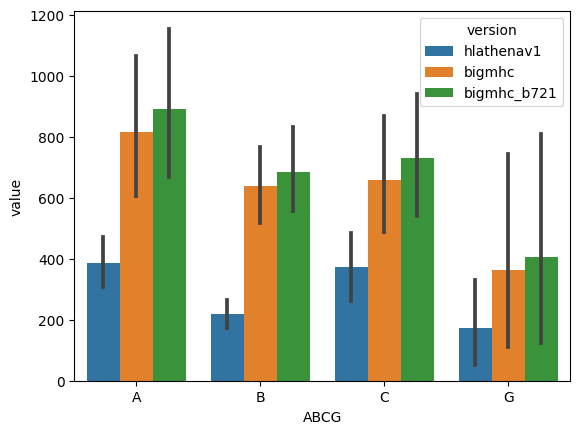

In [88]:
import seaborn as sns
meltdf = pd.melt(hit_cnts, id_vars=['mhc', 'len', 'tgt'], var_name='version') 
meltdf = meltdf.loc[meltdf['len']>=8]
meltdf['ABCG'] = meltdf.mhc.apply(lambda x: x[4])
meltdf.fillna(0, inplace=True)
sns.barplot(meltdf, x="ABCG", y="value", hue="version")


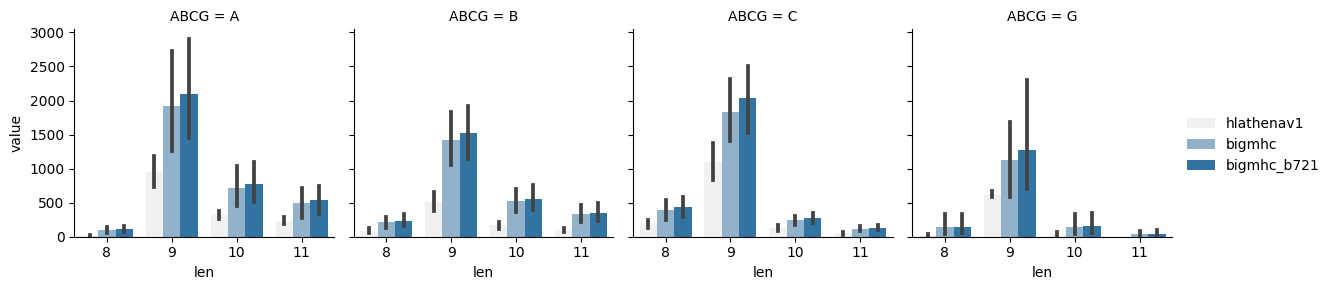

In [90]:
g = sns.FacetGrid(meltdf, col="ABCG")
g.map_dataframe(sns.barplot, x="len", y="value", hue="version")
g.add_legend()

In [96]:
meltdf.loc[(meltdf['len']==11) & (meltdf['version']=='hlathenav1')].value.sum()

17570.0

In [30]:
def clean_allele_names(df, allele_col):
    import re
    replace_regex = '[\*]|(HLA[-|*])|[:]|([N|Q]$)|[ ]|[-]'
    alleles = df[allele_col]
    alleles_clean = [re.sub(replace_regex, "", a) for a in alleles]
    return alleles_clean

In [71]:
# test = df.sample(10000)
import numpy as np
# test['fold'] = np.random.choice(range(2), 10000, replace=True)
# test[['ABCG','fold','set','label']].value_counts()
test.to_csv('../data/test_split.txt', sep=' ', index=None)

In [47]:
import peptides
# “boman”, “hmoment”, “hydrophobicity”, “helixbend”, “sidechain”, “xstr”, “partspec”, “pkc”

In [52]:
df['boman'] = [ peptides.Peptide(s).boman() for s in df['seq'] ]
df['hmoment'] = [ peptides.Peptide(s).hydrophobic_moment() for s in df['seq'] ]
df['hydrophobicity'] = [ peptides.Peptide(s).kidera_factors().kf4 for s in df['seq'] ]
df['helixbend'] = [ peptides.Peptide(s).kidera_factors().kf1 for s in df['seq'] ]
df['sidechain'] = [ peptides.Peptide(s).kidera_factors().kf2 for s in df['seq'] ]
df['xstr'] = [ peptides.Peptide(s).kidera_factors().kf3 for s in df['seq'] ]
df['partspec'] = [ peptides.Peptide(s).kidera_factors().kf6 for s in df['seq'] ]
df['pkc'] = [ peptides.Peptide(s).kidera_factors().kf9 for s in df['seq'] ]




In [2]:
def filterlen(df, minlen=8, maxlen=11):
    """remove peptides of length fewer than 8 or greater than 15 residues"""
    return df[df.pep.apply(lambda x: (len(x) >= minlen) and (len(x) <= maxlen))].copy()


def uid(df):
    """set index as mhc_pep"""
    df["uid"] = df.mhc + '_' + df.pep
    return df.set_index("uid", drop=True)


def dedup(df):
    """remove contradictory pos/neg instances and then deduplicate"""
    # first copy all sorted duplicates and remove them from df
    dupidx = df.index.duplicated(keep=False)
    dups = df[dupidx].copy().sort_index()
    df = df[~dupidx]
    # then remove any contradictory pos/neg instances in the dups
    dups["rm"] = 0
    x = 0
    while x < len(dups)-1:
        rm = 0
        for y in range(x+1,len(dups)):
            if dups.index[x] != dups.index[y]:
                break
            if dups.tgt[x] != dups.tgt[y]:
                rm = 1
        dups.iloc[x:y,-1] = rm
        x = y
    dups = dups[dups.rm==0]
    # lastly deduplicate and concat
    dups = dups[~dups.index.duplicated()]
    dups.drop(["rm"], axis=1, inplace=True)
    return pd.concat((df,dups)).sort_index()


def standardizeDF(df):
    """
    Function to be called on every loaded dataset for
    standardizing MHC and peptide values and deduplication.
    Assumes dataframe has columns: mhc, pep, tgt
    """
    df.mhc = df.mhc.apply(str.upper)
    df.pep = df.pep.apply(str.upper)
    df.tgt = df.tgt.astype(int)
    df = dedup(uid(filterlen(df)))
    return df.sort_index()

In [3]:
og_files = glob.glob('../data/ogdata/*.txt')
og_dfs = [pd.read_csv(f, sep=' ') for f in og_files]
ogdf = pd.concat(og_dfs)
ogdf_hits = ogdf.loc[ogdf.label==1]
ogdf_hits.columns = ['ABCG', 'len', 'mhc', 'seed', 'fold', 'set', 'pep', 'tgt',
       'boman', 'hmoment', 'hydrophobicity', 'helixbend', 'sidechain', 'xstr',
       'partspec', 'pkc']
ogdf_hits['mhc'] = ogdf_hits.mhc.apply(lambda x: f'HLA-{x[0]}*{x[1:3]}:{x[3:]}')

/Users/cleoforman/PycharmProjects/hlathenav2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
og = ogdf_hits[['mhc','pep','tgt']]

In [6]:
standardizeDF(og)

/Users/cleoforman/PycharmProjects/hlathenav2/venv/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,mhc,pep,tgt
uid,,,
HLA-A*01:01_AADIFYSRY,HLA-A*01:01,AADIFYSRY,1
HLA-A*01:01_AADLNLVLY,HLA-A*01:01,AADLNLVLY,1
HLA-A*01:01_AADLVEALY,HLA-A*01:01,AADLVEALY,1
HLA-A*01:01_AIDEDVLRY,HLA-A*01:01,AIDEDVLRY,1
HLA-A*01:01_AIDHNQMFQY,HLA-A*01:01,AIDHNQMFQY,1
...,...,...,...
HLA-G*01:04_VTIKKALTL,HLA-G*01:04,VTIKKALTL,1
HLA-G*01:04_VVAKDGLKL,HLA-G*01:04,VVAKDGLKL,1
HLA-G*01:04_VVAPAGITL,HLA-G*01:04,VVAPAGITL,1


In [8]:
og

,mhc,pep,tgt
0,HLA-A*02:02,TEELAYLK,1
1,HLA-A*02:02,TEELAYLK,1
2,HLA-A*02:02,LQQAKEDL,1
3,HLA-A*02:02,YDKDHYKL,1
4,HLA-A*02:02,YDKDHYKL,1
...,...,...,...
2695494,HLA-G*01:04,KIPTLKISLI,1
2695498,HLA-G*01:04,KLPATEKPVL,1
2695499,HLA-G*01:04,RFPGQLNADL,1
2695501,HLA-G*01:04,FSFPCHQTKL,1


In [9]:
bigmhc = pd.read_csv('/Users/cleoforman/PycharmProjects/hlathenav2/models/data/bigmhc_data/el_hits.csv')

In [10]:
bigmhc

,mhc,pep,tgt
0,HLA-A*01:01,AADIFYSRY,1
1,HLA-A*01:01,AADLNLVLY,1
2,HLA-A*01:01,AADLVEALY,1
3,HLA-A*01:01,AADPLTDLRY,1
4,HLA-A*01:01,AADPNAAWAAY,1
...,...,...,...
313965,HLA-C*17:01,YQILVVTRL,1
313966,HLA-C*17:01,YSAPEILL,1
313967,HLA-C*17:01,YSHPGVVFL,1
313968,HLA-C*17:01,YSVDIPLDK,1


In [11]:
bigmhc = standardizeDF(bigmhc)

In [18]:
bigmhc['src'] = 'BigMHC'

In [19]:
bigmhc.to_csv('/Users/cleoforman/PycharmProjects/hlathenav2/models/data/std_bigmhc.csv')

In [14]:
v3 = pd.read_csv('/Users/cleoforman/PycharmProjects/hlathenav2/models/data/B721_dedup.csv')

In [15]:
v3

,mhc,pep,tgt,src
0,HLA-A*02:04,XFESLTQLQ,1,this
1,HLA-A*02:04,PPYTVVYFPVR,1,this
2,HLA-A*02:04,RLLRPLLLL,1,this
3,HLA-A*02:04,VMAPRTVLL,1,this
4,HLA-A*02:04,SLLDEVALEGL,1,this
...,...,...,...,...
34132,HLA-A*26:01,GIEHGNILQY,1,this
34133,HLA-A*26:01,LDIEQRLQ,1,this
34134,HLA-A*26:01,DTFETPTSY,1,this
34135,HLA-A*26:01,DTVKKIESF,1,this


In [16]:
v3 = standardizeDF(v3)

In [17]:
v3

,mhc,pep,tgt,src
uid,,,,
HLA-A*01:01_ADIIVITVY,HLA-A*01:01,ADIIVITVY,1,this
HLA-A*01:01_AIDPLLFKY,HLA-A*01:01,AIDPLLFKY,1,this
HLA-A*01:01_AIEAVSPGLY,HLA-A*01:01,AIEAVSPGLY,1,this
HLA-A*01:01_ALDDQAFVAY,HLA-A*01:01,ALDDQAFVAY,1,this
HLA-A*01:01_ALDLEIATY,HLA-A*01:01,ALDLEIATY,1,this
...,...,...,...,...
HLA-G*01:04_VIIGKTVTL,HLA-G*01:04,VIIGKTVTL,1,this
HLA-G*01:04_VINPEPITL,HLA-G*01:04,VINPEPITL,1,this
HLA-G*01:04_VIPAEKFDL,HLA-G*01:04,VIPAEKFDL,1,this


In [20]:
v3.to_csv('/Users/cleoforman/PycharmProjects/hlathenav2/models/data/std_B721.csv')

In [100]:
og = pd.read_csv('/Users/cleoforman/PycharmProjects/hlathenav2/models/data/std_og.csv',index_col=0)

In [101]:
og.columns

Index(['mhc', 'pep', 'tgt'], dtype='object')

In [102]:
og['src'] = 'HLAthenaV1'

In [107]:
og.join(bigmhc, how='inner', lsuffix='_bigmhc', rsuffix='_HLAthenaV1')

,mhc_bigmhc,pep_bigmhc,tgt_bigmhc,src_bigmhc,mhc_HLAthenaV1,pep_HLAthenaV1,tgt_HLAthenaV1,src_HLAthenaV1
uid,,,,,,,,
HLA-A*01:01_AADIFYSRY,HLA-A*01:01,AADIFYSRY,1,HLAthenaV1,HLA-A*01:01,AADIFYSRY,1,BigMHC
HLA-A*01:01_AADLNLVLY,HLA-A*01:01,AADLNLVLY,1,HLAthenaV1,HLA-A*01:01,AADLNLVLY,1,BigMHC
HLA-A*01:01_AADLVEALY,HLA-A*01:01,AADLVEALY,1,HLAthenaV1,HLA-A*01:01,AADLVEALY,1,BigMHC
HLA-A*01:01_AIDEDVLRY,HLA-A*01:01,AIDEDVLRY,1,HLAthenaV1,HLA-A*01:01,AIDEDVLRY,1,BigMHC
HLA-A*01:01_AIDHNQMFQY,HLA-A*01:01,AIDHNQMFQY,1,HLAthenaV1,HLA-A*01:01,AIDHNQMFQY,1,BigMHC
...,...,...,...,...,...,...,...,...
HLA-C*17:01_YVGSRPIKL,HLA-C*17:01,YVGSRPIKL,1,HLAthenaV1,HLA-C*17:01,YVGSRPIKL,1,BigMHC
HLA-C*17:01_YVINVTTHL,HLA-C*17:01,YVINVTTHL,1,HLAthenaV1,HLA-C*17:01,YVINVTTHL,1,BigMHC
HLA-C*17:01_YVVPYMIHL,HLA-C*17:01,YVVPYMIHL,1,HLAthenaV1,HLA-C*17:01,YVVPYMIHL,1,BigMHC


In [108]:
og

,mhc,pep,tgt,src
uid,,,,
HLA-A*01:01_AADIFYSRY,HLA-A*01:01,AADIFYSRY,1,HLAthenaV1
HLA-A*01:01_AADLNLVLY,HLA-A*01:01,AADLNLVLY,1,HLAthenaV1
HLA-A*01:01_AADLVEALY,HLA-A*01:01,AADLVEALY,1,HLAthenaV1
HLA-A*01:01_AIDEDVLRY,HLA-A*01:01,AIDEDVLRY,1,HLAthenaV1
HLA-A*01:01_AIDHNQMFQY,HLA-A*01:01,AIDHNQMFQY,1,HLAthenaV1
...,...,...,...,...
HLA-G*01:04_VTIKKALTL,HLA-G*01:04,VTIKKALTL,1,HLAthenaV1
HLA-G*01:04_VVAKDGLKL,HLA-G*01:04,VVAKDGLKL,1,HLAthenaV1
HLA-G*01:04_VVAPAGITL,HLA-G*01:04,VVAPAGITL,1,HLAthenaV1


In [110]:
all = pd.concat([og,bigmhc,v3])

In [112]:
all['len']=all.pep.apply(len)

In [113]:
all

,mhc,pep,tgt,src,len
uid,,,,,
HLA-A*01:01_AADIFYSRY,HLA-A*01:01,AADIFYSRY,1,HLAthenaV1,9
HLA-A*01:01_AADLNLVLY,HLA-A*01:01,AADLNLVLY,1,HLAthenaV1,9
HLA-A*01:01_AADLVEALY,HLA-A*01:01,AADLVEALY,1,HLAthenaV1,9
HLA-A*01:01_AIDEDVLRY,HLA-A*01:01,AIDEDVLRY,1,HLAthenaV1,9
HLA-A*01:01_AIDHNQMFQY,HLA-A*01:01,AIDHNQMFQY,1,HLAthenaV1,10
...,...,...,...,...,...
HLA-G*01:04_VIIGKTVTL,HLA-G*01:04,VIIGKTVTL,1,this,9
HLA-G*01:04_VINPEPITL,HLA-G*01:04,VINPEPITL,1,this,9
HLA-G*01:04_VIPAEKFDL,HLA-G*01:04,VIPAEKFDL,1,this,9


In [115]:
all[[
    'src','mhc','len'
]].value_counts()

src     mhc          len
BigMHC  HLA-A*02:01  9      7848
        HLA-B*07:02  9      5696
        HLA-A*29:02  9      4982
        HLA-B*57:01  9      4864
        HLA-B*15:01  9      4845
                            ... 
        HLA-B*39:10  8         1
        HLA-B*27:10  10        1
                     11        1
        HLA-B*35:06  10        1
        HLA-B*14:03  10        1
Length: 1244, dtype: int64

In [116]:
alleles = all.mhc.unique()

In [130]:
rows = []
for a,df in all.groupby('mhc'):
    LENS=[8,9,10,11]
    for l, d in df.groupby('len'):
        row = [a, l]
        for s in ['HLAthenaV1', 'BigMHC', 'this']:
            if s not in d['src'].value_counts():
                row.append(0)
            else:
                row.append( d['src'].value_counts()[s] )
        rows.append(row)
        # print(a,l)
        # print(d['src'].value_counts())
        # print(row)
        # print(d)
    # break
        # for l in LENS:
            

In [135]:
len_count_df = pd.DataFrame(rows, columns = ['mhc','len','HLAthenaV1','BigMHC','HLAthenaV2'])

In [138]:
rows = []
for a,df in all.groupby('mhc'):
    # LENS=[8,9,10,11]
    # for l, d in df.groupby('len'):
    row = [a]
    for s in ['HLAthenaV1', 'BigMHC', 'this']:
        if s not in df['src'].value_counts():
            row.append(0)
        else:
            row.append( df['src'].value_counts()[s] )
    rows.append(row)
allele_count_df = pd.DataFrame(rows, columns = ['mhc','HLAthenaV1','BigMHC','HLAthenaV2'])

In [143]:
meltdf = allele_count_df.melt(id_vars=['mhc'])

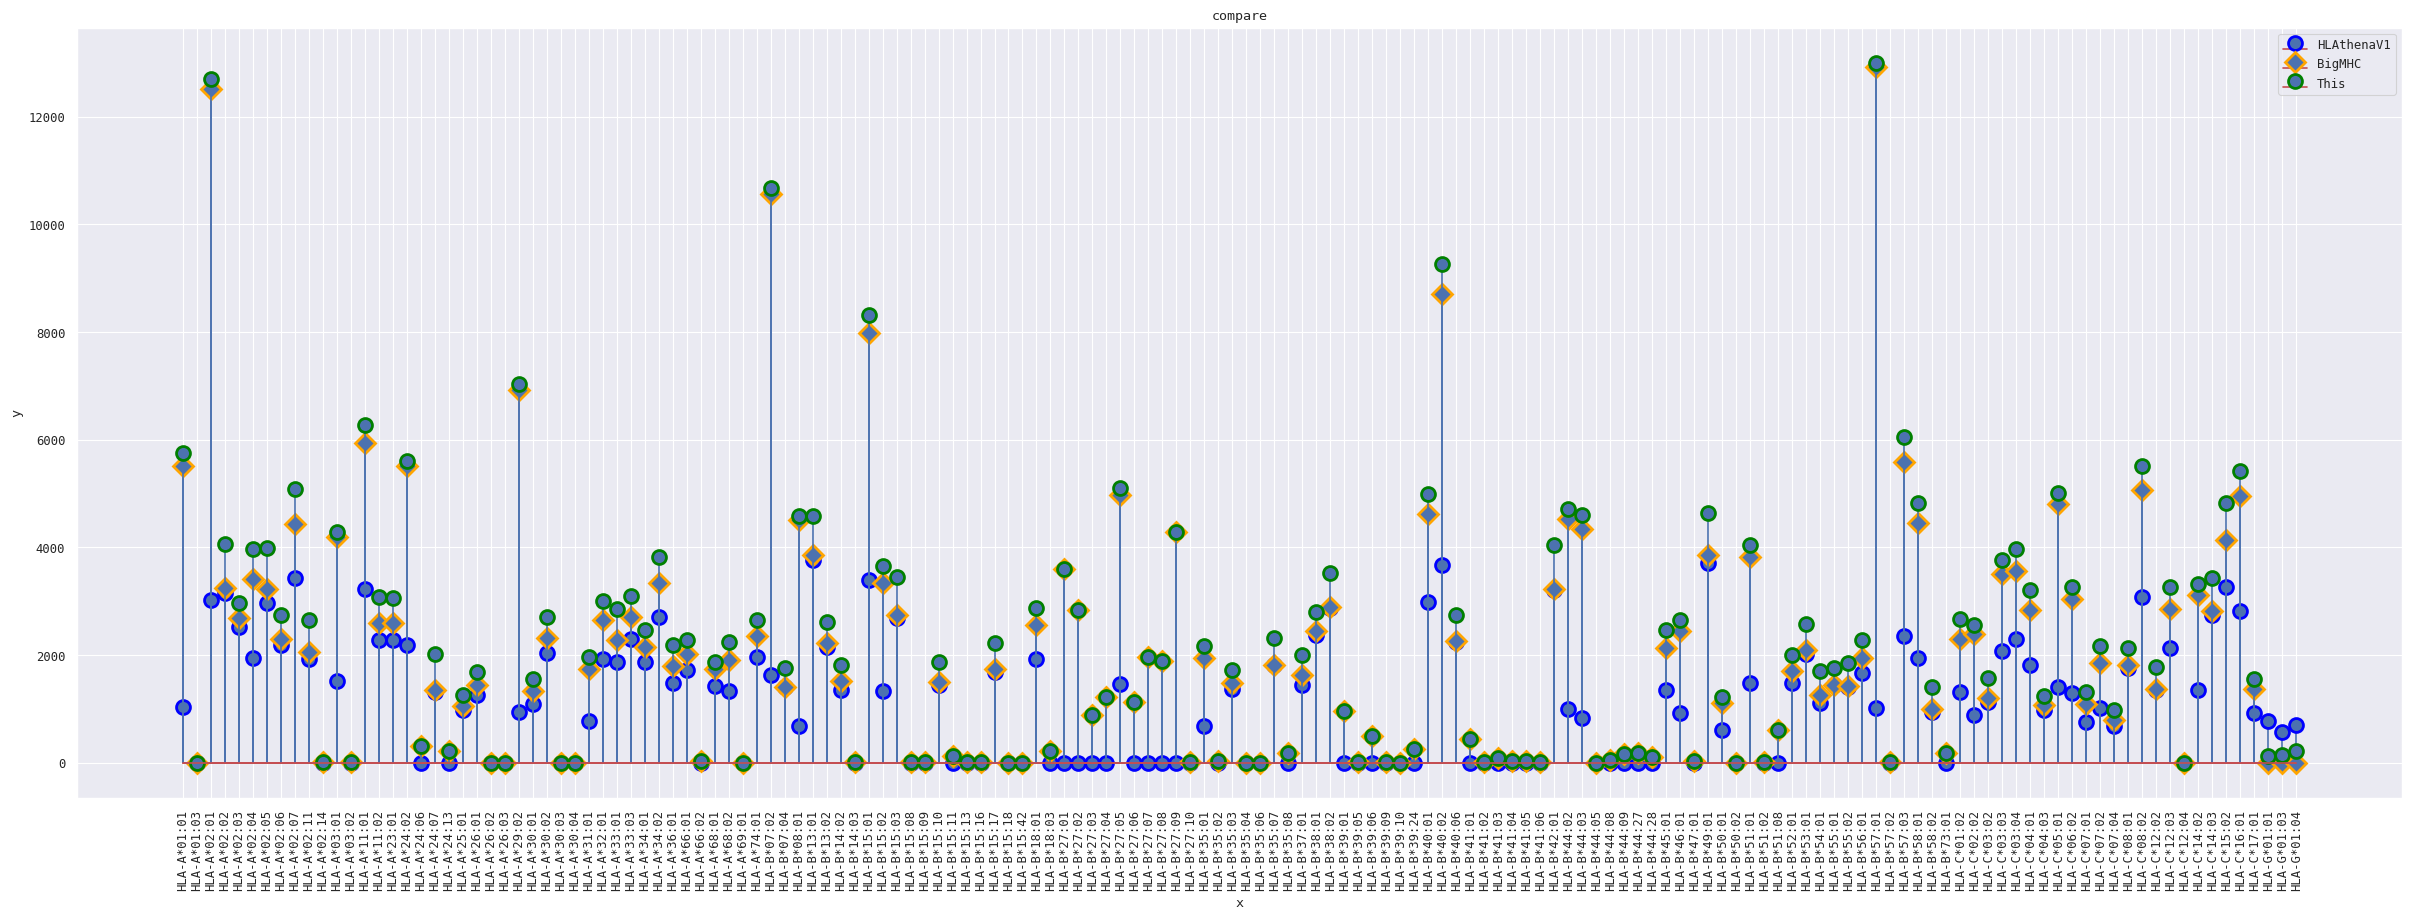

In [204]:
f, ax = plt.subplots(figsize=(30, 10))
x = allele_count_df['mhc']
# create an index for each tick position
xi = list(range(len(x)))

y = allele_count_df['HLAthenaV1']
# plt.ylim(0.8,1.4)
# plot the index for the x-values
(markers, stemlines, baseline) = plt.stem(xi, y, label='HLAthenaV1')
plt.setp(markers, marker='o', markersize=10, markeredgecolor="blue", markeredgewidth=2, markerfacecolor=None)

# plt.stem(xi, y, markerfmt='o') 

y2 = allele_count_df['BigMHC']

(markers, stemlines, baseline) = plt.stem(xi, y2, label='BigMHC')
 # = plt.stem(values)
plt.setp(markers, marker='D', markersize=10, markeredgecolor="orange", markeredgewidth=2)

y3 = allele_count_df['Total']
(markers, stemlines, baseline) = plt.stem(xi, y3, label='This')
 # = plt.stem(values)
plt.setp(markers, marker='o', markersize=10, markeredgecolor="green", markeredgewidth=2)

plt.xlabel('x')
plt.ylabel('y') 
plt.xticks(xi, x, rotation=90)
plt.title('compare')
plt.legend() 
plt.show()

In [199]:
allele_count_df['Total'] = allele_count_df[['BigMHC','HLAthenaV2']].sum(axis=1, numeric_only=True)


In [200]:
allele_count_df

,mhc,HLAthenaV1,BigMHC,HLAthenaV2,Total
0,HLA-A*01:01,1040,5516,243,5759
1,HLA-A*01:03,0,5,0,5
2,HLA-A*02:01,3023,12504,193,12697
3,HLA-A*02:02,3151,3251,811,4062
4,HLA-A*02:03,2530,2697,265,2962
...,...,...,...,...,...
147,HLA-C*16:01,2816,4960,465,5425
148,HLA-C*17:01,923,1366,190,1556
149,HLA-G*01:01,770,0,134,134
150,HLA-G*01:03,579,0,145,145


In [205]:
bigmhc

,mhc,pep,tgt,src
uid,,,,
HLA-A*01:01_AAAHTHRY,HLA-A*01:01,AAAHTHRY,1,BigMHC
HLA-A*01:01_AADIFYSRY,HLA-A*01:01,AADIFYSRY,1,BigMHC
HLA-A*01:01_AADLNLVLY,HLA-A*01:01,AADLNLVLY,1,BigMHC
HLA-A*01:01_AADLVEALY,HLA-A*01:01,AADLVEALY,1,BigMHC
HLA-A*01:01_AADPLTDLRY,HLA-A*01:01,AADPLTDLRY,1,BigMHC
...,...,...,...,...
HLA-C*17:01_YVINVTTHL,HLA-C*17:01,YVINVTTHL,1,BigMHC
HLA-C*17:01_YVQSMDVAAF,HLA-C*17:01,YVQSMDVAAF,1,BigMHC
HLA-C*17:01_YVVPYMIHL,HLA-C*17:01,YVVPYMIHL,1,BigMHC


In [207]:
pd.concat([bigmhc,og]).index.duplicated()

array([False, False, False, ..., False, False, False])

In [209]:
og

,mhc,pep,tgt,src,len
uid,,,,,
HLA-A*01:01_AADIFYSRY,HLA-A*01:01,AADIFYSRY,1,HLAthenaV1,9
HLA-A*01:01_AADLNLVLY,HLA-A*01:01,AADLNLVLY,1,HLAthenaV1,9
HLA-A*01:01_AADLVEALY,HLA-A*01:01,AADLVEALY,1,HLAthenaV1,9
HLA-A*01:01_AIDEDVLRY,HLA-A*01:01,AIDEDVLRY,1,HLAthenaV1,9
HLA-A*01:01_AIDHNQMFQY,HLA-A*01:01,AIDHNQMFQY,1,HLAthenaV1,10
...,...,...,...,...,...
HLA-G*01:04_VTIKKALTL,HLA-G*01:04,VTIKKALTL,1,HLAthenaV1,9
HLA-G*01:04_VVAKDGLKL,HLA-G*01:04,VVAKDGLKL,1,HLAthenaV1,9
HLA-G*01:04_VVAPAGITL,HLA-G*01:04,VVAPAGITL,1,HLAthenaV1,9


In [226]:
merge = og.merge(bigmhc, on='uid', how='right')
merge = merge.loc[merge['src_x'] != 'HLAthenaV1']
bigmhc_unique = merge[['mhc_y','pep_y','tgt_y','src_y']]

In [230]:
bigmhc_unique['len'] = bigmhc_unique.pep.apply(len)
v3['len'] = v3.pep.apply(len)


/Users/cleoforman/PycharmProjects/hlathenav2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [233]:
all = pd.concat([bigmhc_unique,v3,og])

In [243]:
rows = []
for a,df in all.groupby('mhc'):
    # LENS=[8,9,10,11]
    # for l, d in df.groupby('len'):
    row = [a]
    for s in ['HLAthenaV1', 'BigMHC', 'this']:
        if s not in df['src'].value_counts():
            row.append(0)
        else:
            row.append( df['src'].value_counts()[s] )
    rows.append(row)
allele_count_df = pd.DataFrame(rows, columns = ['mhc','HLAthenaV1','BigMHC','HLAthenaV2'])

In [244]:
allele_count_df

,mhc,HLAthenaV1,BigMHC,HLAthenaV2
0,HLA-A*01:01,1040,4477,243
1,HLA-A*01:03,0,5,0
2,HLA-A*02:01,3023,9511,193
3,HLA-A*02:02,3151,105,811
4,HLA-A*02:03,2530,185,265
...,...,...,...,...
147,HLA-C*16:01,2816,2176,465
148,HLA-C*17:01,923,459,190
149,HLA-G*01:01,770,0,134
150,HLA-G*01:03,579,0,145


In [245]:
allele_count_df['V1+BigMHC'] = allele_count_df[['BigMHC','HLAthenaV1']].sum(axis=1, numeric_only=True)
allele_count_df['V1+BigMHC+V2'] = allele_count_df[['BigMHC','HLAthenaV1','HLAthenaV2']].sum(axis=1, numeric_only=True)


ValueError: 0       blue
2       blue
3       blue
4       blue
5       blue
       ...  
147    green
148    green
149      red
150      red
151      red
Name: loci, Length: 125, dtype: object is not a valid value for color

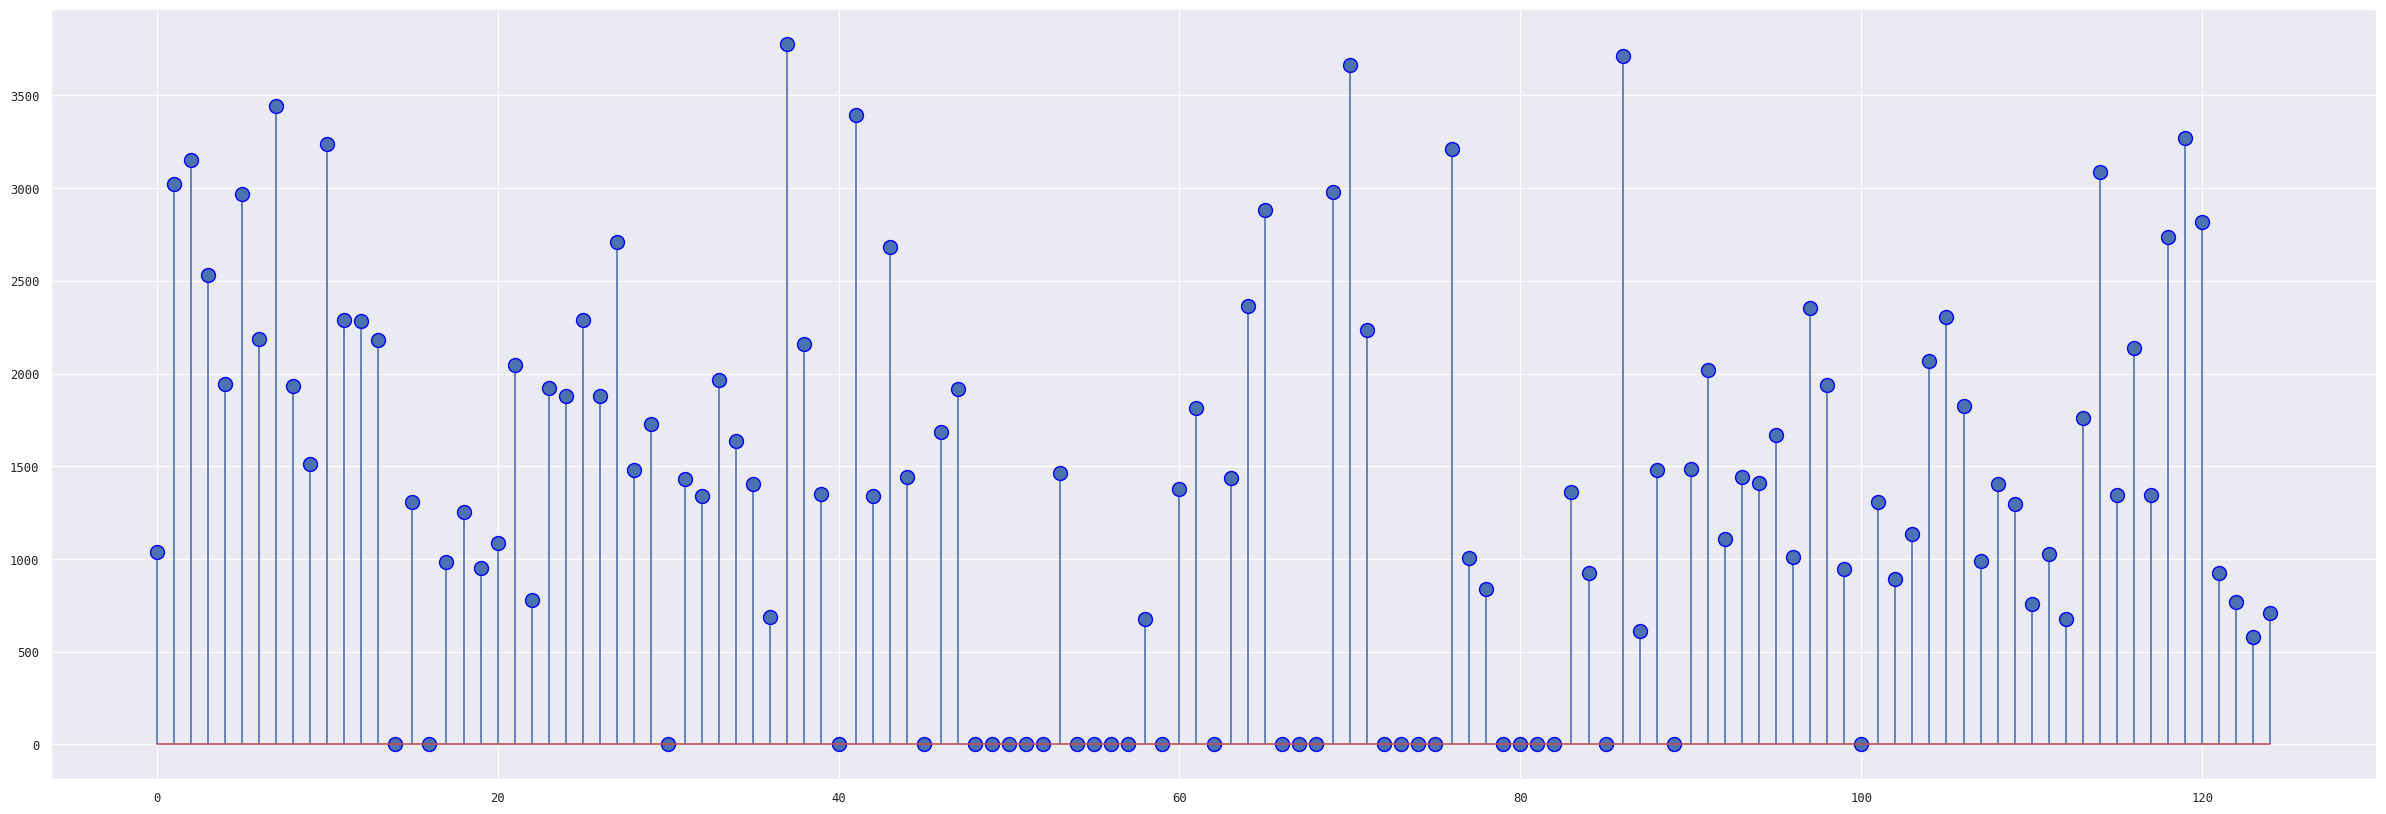

In [264]:
f, ax = plt.subplots(figsize=(30, 10))
x = allele_count_df['mhc']

colors = {'A':'purple', 'B':'blue', 'C':'orange', 'G':'yellow'}

# ax.scatter(df['carat'], df['price'], c=allele_count_df['loci'].map(colors))

# create an index for each tick position
xi = list(range(len(x)))

y = allele_count_df['HLAthenaV1']
# plt.ylim(0.8,1.4)
# plot the index for the x-values
(markers, stemlines, baseline) = plt.stem(xi, y, label='HLAthenaV1')
plt.setp(markers, marker='o', markersize=10, markeredgecolor='blue', color=allele_count_df['loci'].map(colors), markeredgewidth=2, markerfacecolor=None)

# plt.stem(xi, y, markerfmt='o') 

y2 = allele_count_df['V1+BigMHC']

(markers, stemlines, baseline) = plt.stem(xi, y2, label='Published data')
 # = plt.stem(values)
plt.setp(markers, marker='D', markersize=10, markeredgecolor="orange", markeredgewidth=2)

y3 = allele_count_df['V1+BigMHC+V2']
(markers, stemlines, baseline) = plt.stem(xi, y3, label='This')
 # = plt.stem(values)
plt.setp(markers, marker='o', markersize=10, markeredgecolor="green", markeredgewidth=2)

plt.xlabel('x')
plt.ylabel('y') 
plt.xticks(xi, x, rotation=90)
plt.title('compare')
plt.legend() 
plt.show()

In [247]:
allele_count_df['drop'] = allele_count_df['V1+BigMHC+V2'].apply(lambda x: x<20)

In [265]:
markers

In [241]:
allele_count_df.drop(allele_count_df['drop'].index, inplace=True)


In [242]:
allele_count_df

,mhc,HLAthenaV1,BigMHC,HLAthenaV2,V1+BigMHC,V1+BigMHC+V2,drop


In [252]:
allele_count_df = allele_count_df[~allele_count_df['drop']]

In [254]:
allele_count_df['loci'] = allele_count_df['mhc'].apply(lambda x: x[4])

/Users/cleoforman/PycharmProjects/hlathenav2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [255]:
allele_count_df

,mhc,HLAthenaV1,BigMHC,HLAthenaV2,V1+BigMHC,V1+BigMHC+V2,drop,loci
0,HLA-A*01:01,1040,4477,243,5517,5760,False,A
2,HLA-A*02:01,3023,9511,193,12534,12727,False,A
3,HLA-A*02:02,3151,105,811,3256,4067,False,A
4,HLA-A*02:03,2530,185,265,2715,2980,False,A
5,HLA-A*02:04,1946,1476,569,3422,3991,False,A
...,...,...,...,...,...,...,...,...
147,HLA-C*16:01,2816,2176,465,4992,5457,False,C
148,HLA-C*17:01,923,459,190,1382,1572,False,C
149,HLA-G*01:01,770,0,134,770,904,False,G
150,HLA-G*01:03,579,0,145,579,724,False,G


In [308]:
from matplotlib.ticker import ScalarFormatter

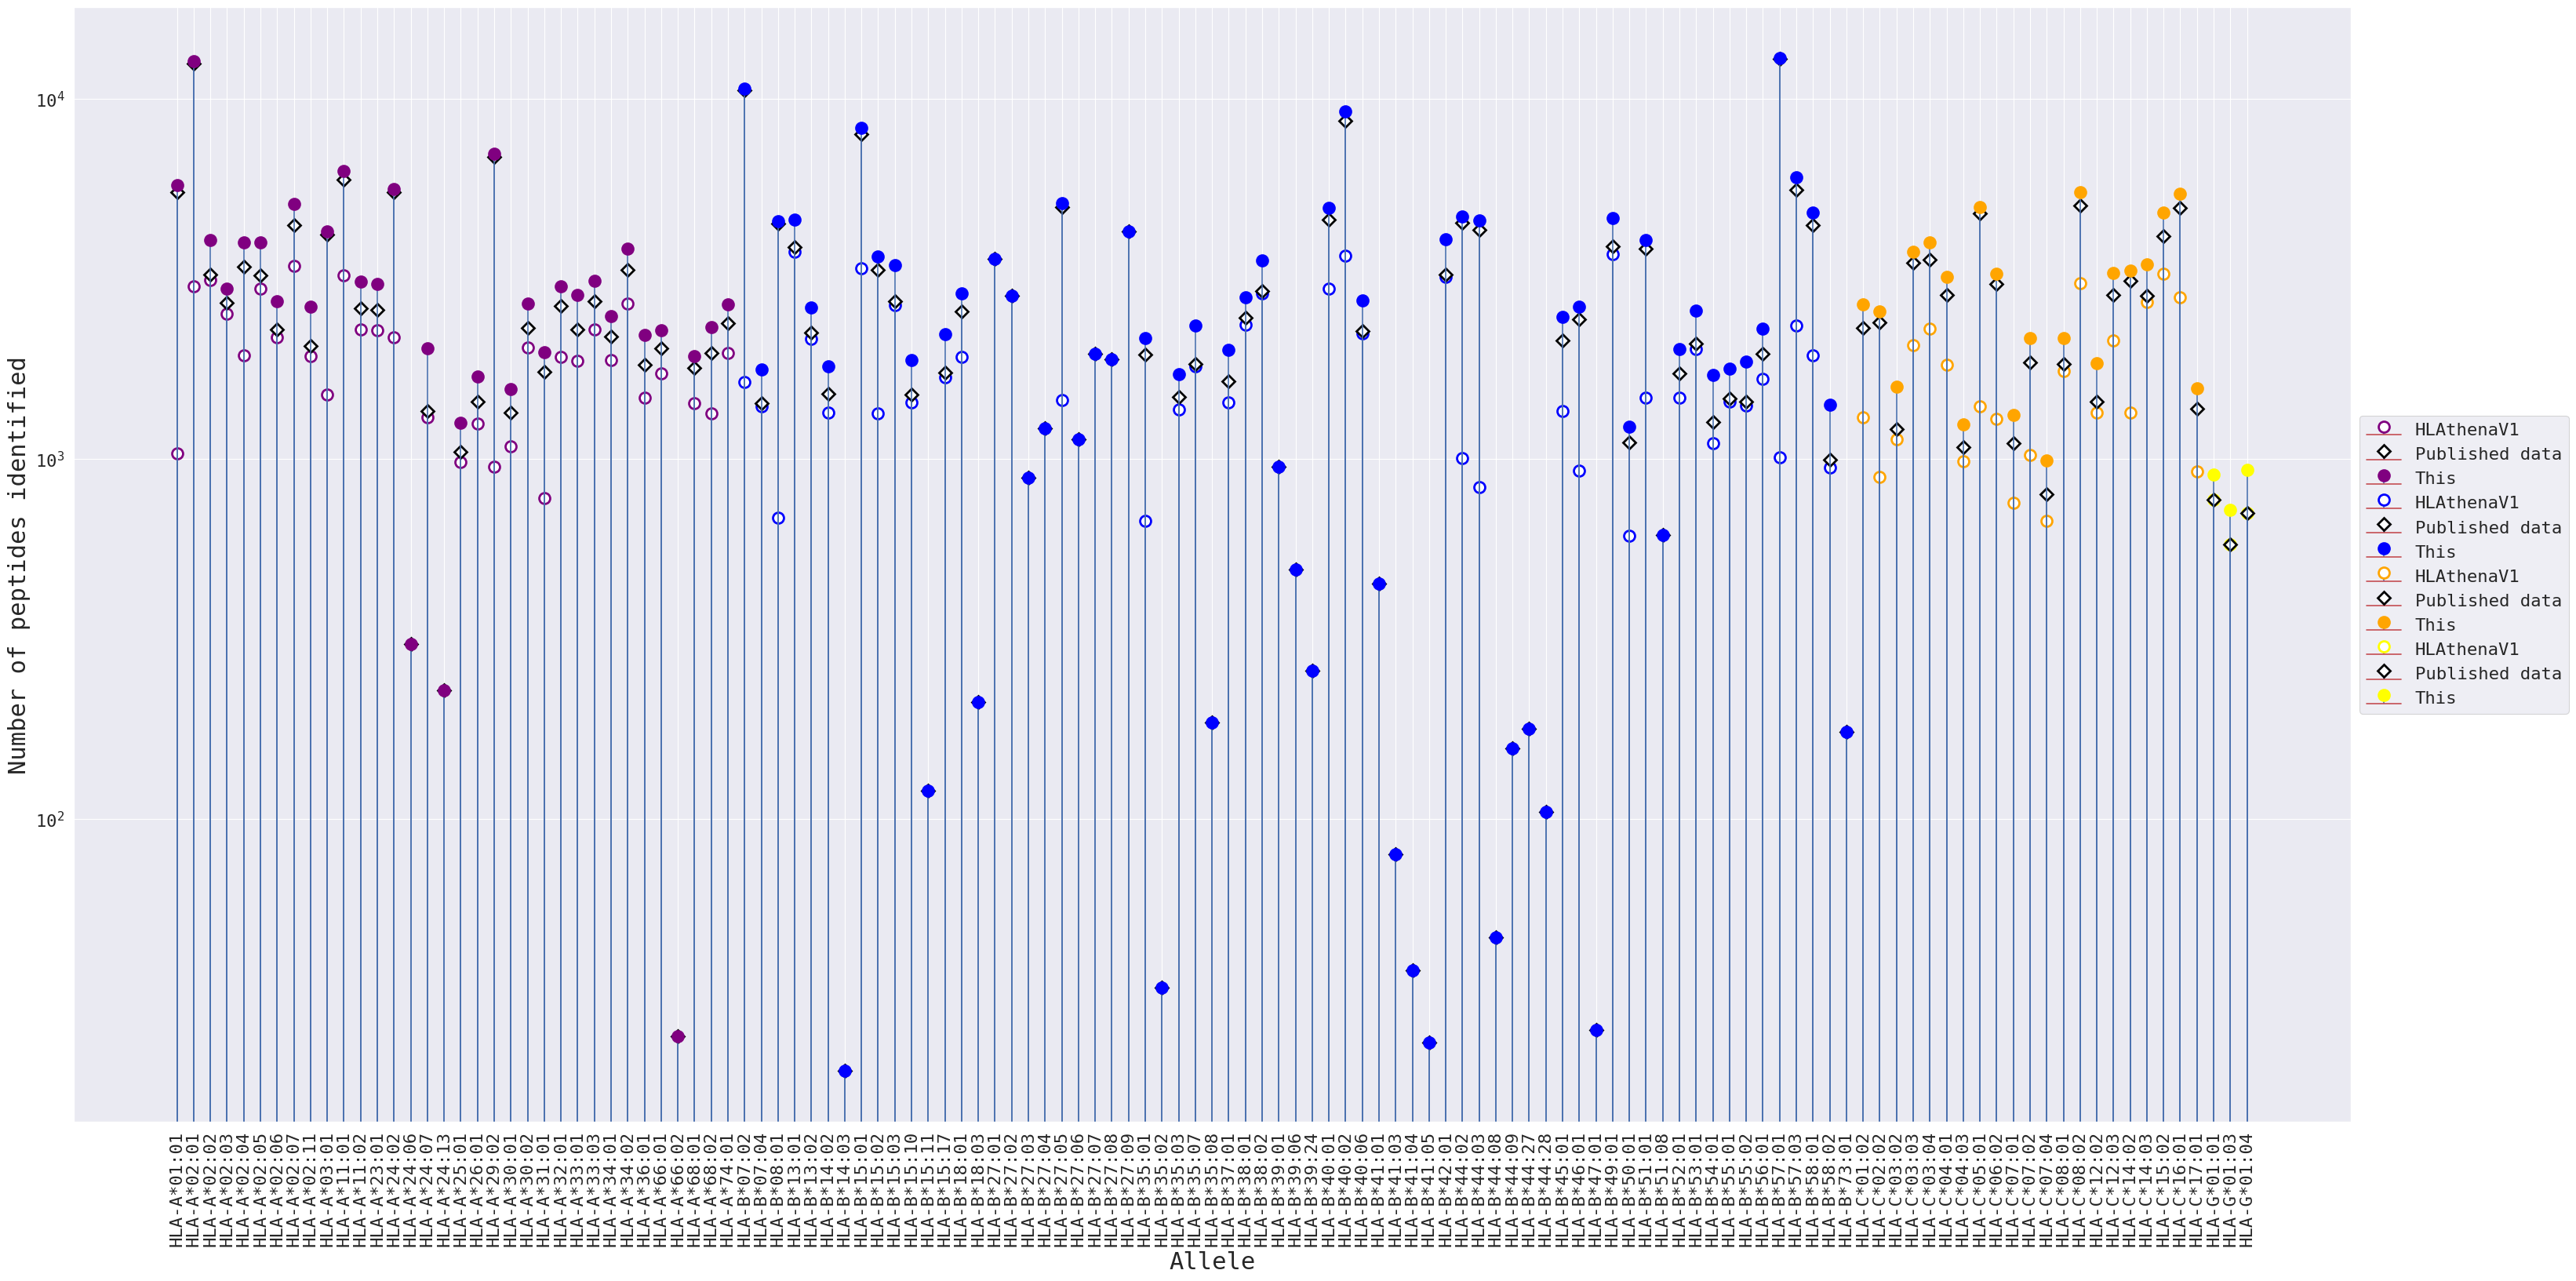

In [339]:
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, ax = plt.subplots(figsize=(30, 15))
ax.set_yscale('log')
ax.tick_params(which='both', width=2)

# x = allele_count_df['mhc']

colors = {'A':'purple', 'B':'blue', 'C':'orange', 'G':'yellow'}
start,end = 0,0
for loci, df in allele_count_df.groupby('loci'):
    c = colors[loci]
    x = df['mhc']
    end = end + len(x)
    xi = list(range(start, end))
    start = end
    y1 = df['HLAthenaV1']
    (markers, stemlines, baseline) = ax.stem(xi, y1, label='HLAthenaV1')
    plt.setp(markers, marker='o', markersize=10, markeredgecolor=c, markeredgewidth=2, markerfacecolor='white')

    y2 = df['V1+BigMHC']
    (markers, stemlines, baseline) = ax.stem(xi, y2, label='Published data')
    plt.setp(markers, marker='D', markersize=8, markeredgecolor='black', markeredgewidth=2, markerfacecolor='white')
    
    y3 = df['V1+BigMHC+V2']
    (markers, stemlines, baseline) = plt.stem(xi, y3, label='This')
     # = plt.stem(values)
    plt.setp(markers, marker='o', markersize=10, markeredgecolor=c, color=c, markeredgewidth=2)



x = allele_count_df['mhc']
xi = list(range(len(x)))

# ax.set_facecolor('white')
plt.tight_layout()
# plt.grid(True)
plt.xlabel('Allele')
plt.ylabel('Number of peptides identified') 

plt.xticks(xi, x, rotation=90)
plt.title('')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
plt.savefig('/Users/cleoforman/PycharmProjects/hlathenav2/models/figs/allele_count_lollipop.pdf', transparent=True, format='pdf' , bbox_inches='tight')
plt.show()


In [341]:
bigmhc_unique.to_csv('/Users/cleoforman/PycharmProjects/hlathenav2/models/data/std_bigmhc_unique.csv')
